In [9]:
import networkx as nx 
import matplotlib.pyplot as plt

In [34]:
## a) 

# Load the GraphML file
G = nx.read_graphml('student_graph.graphml')

# Check node attributes
print("Node attributes:")
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")

# Quick visualization
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold')
plt.title("Student Friendship Network")
plt.show()

# Get all node attributes
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

AttributeError: 'NodeView' object has no attribute 'node'

In [13]:
# Then import and use it
import torch
from torch_geometric.utils import from_networkx

# Important: Clear the graph-level attributes to avoid bugs
G.graph = {}

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G, group_node_attrs=["like_sports", "like_music", "like_science"])

# Display the converted data
print(data)
print(f"\nNode features shape (x): {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")

# Check the first few node features
print(f"\nFirst 5 node feature vectors:\n{data.x[:5]}")

Data(edge_index=[2, 1356], name=[100], club=[100], x=[100, 3])

Node features shape (x): torch.Size([100, 3])
Edge index shape: torch.Size([2, 1356])
Number of nodes: 100
Number of edges: 1356
Number of node features: 3

First 5 node feature vectors:
tensor([[0.7955, 0.2209, 0.0432],
        [0.5391, 0.4640, 0.1063],
        [0.7570, 0.0174, 0.4427],
        [0.7885, 0.5266, 0.1933],
        [0.4858, 0.4569, 0.4903]])


## Data Object Structure

**Overall representation:**
`Data(edge_index=[2, 1356], name=[100], club=[100], x=[100, 3])`

This PyTorch Geometric Data object contains four main attributes [1][4][5]:

### 1. **x=[9]** - Node Feature Matrix
This is the core input for your GNN model. It contains 100 rows (one per student) and 3 columns (the three "like" attributes: sports, music, science) [2][6]. The first 5 students' features show their preference scores:
- Student 0: Strong sports preference (0.7955), weak music (0.2209), weak science (0.0432)
- Student 1: Moderate sports (0.5391) and music (0.4640), weak science (0.1063)
- Student 2: Strong sports (0.7570) and science (0.4427), very weak music (0.0174)

### 2. **edge_index=[10]** - Graph Connectivity
This represents the friendship network in COO (Coordinate) format with shape `[2, num_edges]` [1][2][5]. The network has **1,356 edges** (678 undirected friendships × 2, since each friendship is stored in both directions). The first row contains source nodes, and the second row contains target nodes [1][2].

### 3. **club=** - Target Labels
This attribute stores the club membership for all 100 students (Sports/Music/Science). This is your target variable for node classification and wasn't included in the feature matrix `x` because you didn't specify it in `group_node_attrs` [4][6].

### 4. **name=** - Node Names
This preserves the student names (Student_0 through Student_99) as metadata [4][6].

## Key Insights

The network is **relatively dense** with 1,356 edges connecting 100 nodes (approximately 13.56 edges per node on average). This high connectivity suggests students have multiple friendships, which will help the GNN propagate information effectively during training. The node features clearly distinguish preferences, which combined with the network structure should enable accurate club membership prediction [2][5].


In [14]:
## c) Check what's inside the data object
print("Data object attributes:")
print(f"- edge_index: {data.edge_index.shape} - Graph connectivity")
print(f"- x: {data.x.shape} - Node features (like_sports, like_music, like_science)")
print(f"- club: {len(data.club)} elements - Club membership labels")
print(f"- name: {len(data.name)} elements - Student names")

print(f"\nSample edge_index (first 5 edges):\n{data.edge_index[:, :5]}")
print(f"\nSample node features (first 3 students):\n{data.x[:3]}")
print(f"\nSample club labels (first 5): {data.club[:5]}")


Data object attributes:
- edge_index: torch.Size([2, 1356]) - Graph connectivity
- x: torch.Size([100, 3]) - Node features (like_sports, like_music, like_science)
- club: 100 elements - Club membership labels
- name: 100 elements - Student names

Sample edge_index (first 5 edges):
tensor([[ 0,  0,  0,  0,  0],
        [ 5,  9, 12, 13, 14]])

Sample node features (first 3 students):
tensor([[0.7955, 0.2209, 0.0432],
        [0.5391, 0.4640, 0.1063],
        [0.7570, 0.0174, 0.4427]])

Sample club labels (first 5): ['Sports', 'Sports', 'Sports', 'Sports', 'Sports']


In [16]:
### d) 
from sklearn.preprocessing import LabelEncoder
import torch

# Encode the class (club) using sklearn LabelEncoder
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.club)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)

# Add labels to the data object
data.y = target_tensor
data.num_classes = len(set(data.club))

print(f"\nLabel encoding:")
print(f"Original clubs: {encoder.classes_}")
print(f"Encoded labels (first 10): {data.y[:10]}")
print(f"Number of classes: {data.num_classes}")


Label encoding:
Original clubs: ['Music' 'Science' 'Sports']
Encoded labels (first 10): tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Number of classes: 3


In [18]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Create train/test split
num_nodes = data.num_nodes
train_ratio = 0.80  # 80% of nodes for training

# Randomly creating masks
mask = torch.rand(num_nodes) < train_ratio
data.train_mask = mask
data.test_mask = ~data.train_mask  # Note: ~ (not ˜) for negation

# Remove the attributes for nodes not in the training set
temp = torch.zeros((num_nodes, 3), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp

# Verify the split
print(f"\nTrain/Test split:")
print(f"Training nodes: {data.train_mask.sum().item()} ({data.train_mask.sum().item()/num_nodes*100:.1f}%)")
print(f"Test nodes: {data.test_mask.sum().item()} ({data.test_mask.sum().item()/num_nodes*100:.1f}%)")

# Check that test node features are zeroed out
print(f"\nTest node features (should be zeros):")
print(f"Sample test node: {data.x[data.test_mask][0]}")
print(f"Sample train node: {data.x[data.train_mask][0]}")


Train/Test split:
Training nodes: 78 (78.0%)
Test nodes: 22 (22.0%)

Test node features (should be zeros):
Sample test node: tensor([0., 0., 0.])
Sample train node: tensor([0.7570, 0.0174, 0.4427])


## Line-by-Line Explanation

### Before the code runs:
- `data.x` contains ALL 100 students' features (preferences)
- You want to simulate that 22 test students have **unknown/missing** preferences
- Solution: Replace test node features with zeros while keeping train node features

### Line 1: `temp = torch.zeros((num_nodes, 3), dtype=torch.float)`

**What it does:** Creates a NEW tensor filled with zeros
- Shape: `(100, 3)` - 100 students, 3 features each
- All values are 0.0

**Visualization:**
```
temp = [[0., 0., 0.],   # Student 0
        [0., 0., 0.],   # Student 1
        [0., 0., 0.],   # Student 2
        ...
        [0., 0., 0.]]   # Student 99
```

### Line 2: `temp[data.train_mask] = data.x[data.train_mask]`

**What it does:** Copies ONLY the training nodes' features from the original `data.x` into `temp`

**Breaking it down:**
- `data.train_mask` is a boolean tensor: `[True, True, False, True, ..., False]` (78 True values, 22 False values)
- `data.x[data.train_mask]` selects only the rows where mask is True (78 training students' features)
- `temp[data.train_mask]` selects the same positions in temp and assigns the values

**Visualization after this line:**
```
temp = [[0.7955, 0.2209, 0.0432],   # Student 0 (train) - COPIED
        [0.5391, 0.4640, 0.1063],   # Student 1 (train) - COPIED  
        [0., 0., 0.],               # Student 2 (test) - STAYS ZERO
        [0.7885, 0.5266, 0.1933],   # Student 3 (train) - COPIED
        ...
        [0., 0., 0.]]               # Student 99 (test) - STAYS ZERO
```

### Line 3: `data.x = temp`

**What it does:** Replaces the original feature matrix with the modified one

Now `data.x` contains:
- **Training nodes**: Original preference values preserved
- **Test nodes**: All zeros (simulating missing/unknown preferences)

## Why This Approach?

This masking technique creates a **semi-supervised learning scenario**. The GNN will:
1. See the graph structure (edges) for ALL nodes
2. Have features only for training nodes (78 students)
3. Must learn to predict test nodes' clubs by propagating information through edges from their training neighbors
Without graph structure, predicting clubs for nodes with zero features would be impossible. But GNNs can leverage the friendship network to infer missing information - that's their superpower!


In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        # Single GCN layer
        self.conv1 = GCNConv(num_features, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Apply GCN convolution
        x = self.conv1(x, edge_index)
        
        # Apply log softmax for classification
        return F.log_softmax(x, dim=1)

# Initialize the model
model = GCN(num_features=data.num_node_features, num_classes=data.num_classes)
print(model)
print(f"\nModel parameters:")
print(f"- Input features: {data.num_node_features}")
print(f"- Output classes: {data.num_classes}")


GCN(
  (conv1): GCNConv(3, 3)
)

Model parameters:
- Input features: 3
- Output classes: 3


In [21]:
# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# Training loop
model.train()
num_epochs = 200

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data)
    
    # Calculate loss only on training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

print("\nTraining complete!")


Epoch 20/200, Loss: 0.7941
Epoch 40/200, Loss: 0.6431
Epoch 60/200, Loss: 0.5411
Epoch 80/200, Loss: 0.4720
Epoch 100/200, Loss: 0.4243
Epoch 120/200, Loss: 0.3901
Epoch 140/200, Loss: 0.3647
Epoch 160/200, Loss: 0.3453
Epoch 180/200, Loss: 0.3301
Epoch 200/200, Loss: 0.3179

Training complete!


In [22]:
# Evaluation
model.eval()

with torch.no_grad():
    # Get predictions
    pred = model(data).argmax(dim=1)
    
    # Calculate accuracy on test set only
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    
    print(f'\nTest Accuracy: {acc:.4f}')
    
    # Check training accuracy for comparison
    train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    train_acc = int(train_correct) / int(data.train_mask.sum())
    print(f'Train Accuracy: {train_acc:.4f}')
    
    # Show some predictions
    print(f'\nTest set size: {data.test_mask.sum().item()} nodes')
    print(f'Correctly classified: {correct.item()} nodes')
    print(f'Incorrectly classified: {data.test_mask.sum().item() - correct.item()} nodes')



Test Accuracy: 0.9545
Train Accuracy: 0.9103

Test set size: 22 nodes
Correctly classified: 21 nodes
Incorrectly classified: 1 nodes


In [23]:
# Check the add_self_loops parameter
print("GCNConv default parameters:")
print(f"add_self_loops: {model.conv1.add_self_loops}")

# Possible to explicitly set it when creating the layer:
# self.conv1 = GCNConv(num_features, num_classes, add_self_loops=True)


GCNConv default parameters:
add_self_loops: True


**What `add_self_loops` means:**

By default, `add_self_loops=True` in GCNConv. This adds a self-loop (an edge from each node to itself) to the graph during the convolution operation.

**Why it matters:**
- **Without self-loops:** A node only aggregates information from its neighbors, not including its own features
- **With self-loops:** A node aggregates information from neighbors AND includes its own current features in the aggregation

**Mathematical impact:**
- Without: $$h_i^{new} = \text{aggregate}(\{h_j : j \in N(i)\})$$ - only neighbors
- With: $$h_i^{new} = \text{aggregate}(\{h_j : j \in N(i) \cup \{i\}\})$$ - neighbors + self

**For this problem:** This is crucial! For training nodes with actual features, self-loops allow them to preserve their own preference information while also considering friends' information. For test nodes with zero features, self-loops won't help much (0 + neighbors), so they rely entirely on neighbor aggregation.


In [25]:
# Get predictions for all nodes
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)

# Print targets and predictions for all nodes
print("\n" + "="*60)
print("TARGETS vs PREDICTIONS FOR ALL NODES")
print("="*60)

# Get the class names from encoder
class_names = encoder.classes_

print(f"\n{'Node':<6} {'True Club':<12} {'Predicted':<12} {'Correct?':<10} {'Type':<8}")
print("-" * 60)

for i in range(data.num_nodes):
    true_label = data.y[i].item()
    pred_label = pred[i].item()
    true_club = class_names[true_label]
    pred_club = class_names[pred_label]
    is_correct = "✓" if true_label == pred_label else "✗"
    node_type = "TRAIN" if data.train_mask[i] else "TEST"
    
    print(f"{i:<6} {true_club:<12} {pred_club:<12} {is_correct:<10} {node_type:<8}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

train_correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
train_acc = int(train_correct) / int(data.train_mask.sum())
test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
test_acc = int(test_correct) / int(data.test_mask.sum())

print(f"Training Accuracy: {train_acc:.4f} ({train_correct}/{data.train_mask.sum()})")
print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{data.test_mask.sum()})")



TARGETS vs PREDICTIONS FOR ALL NODES

Node   True Club    Predicted    Correct?   Type    
------------------------------------------------------------
0      Sports       Sports       ✓          TEST    
1      Sports       Sports       ✓          TEST    
2      Sports       Sports       ✓          TRAIN   
3      Sports       Sports       ✓          TEST    
4      Sports       Sports       ✓          TRAIN   
5      Sports       Sports       ✓          TRAIN   
6      Sports       Sports       ✓          TRAIN   
7      Sports       Sports       ✓          TRAIN   
8      Sports       Sports       ✓          TEST    
9      Sports       Sports       ✓          TRAIN   
10     Sports       Sports       ✓          TEST    
11     Sports       Sports       ✓          TRAIN   
12     Sports       Sports       ✓          TEST    
13     Sports       Sports       ✓          TRAIN   
14     Sports       Sports       ✓          TRAIN   
15     Sports       Sports       ✓          TRAIN   

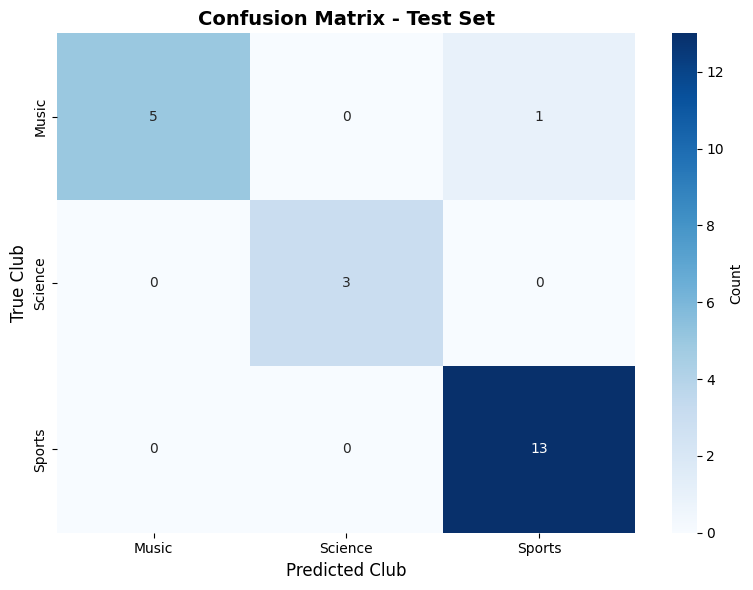


Confusion Matrix (Test Set):
                  Music   Science    Sports
--------------------------------------------------
       Music          5         0         1
     Science          0         3         0
      Sports          0         0        13

PER-CLASS PERFORMANCE

Music:
  Precision: 1.0000
  Recall: 0.8333
  F1-Score: 0.9091

Science:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Sports:
  Precision: 0.9286
  Recall: 1.0000
  F1-Score: 0.9630


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix for test set
confmat = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confmat, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Club', fontsize=12)
plt.ylabel('True Club', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("\nConfusion Matrix (Test Set):")
print("="*50)
print(f"{'':>12} ", end="")
for name in class_names:
    print(f"{name:>10}", end="")
print()
print("-"*50)

for i, true_name in enumerate(class_names):
    print(f"{true_name:>12} ", end="")
    for j in range(len(class_names)):
        print(f"{confmat[i][j]:>10}", end="")
    print()

# Calculate per-class metrics
print("\n" + "="*50)
print("PER-CLASS PERFORMANCE")
print("="*50)

for i, club_name in enumerate(class_names):
    # True positives, false positives, false negatives
    tp = confmat[i, i]
    fp = confmat[:, i].sum() - tp
    fn = confmat[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{club_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


## Understanding the Confusion Matrix

The confusion matrix shows:
- **Rows:** True club membership
- **Columns:** Predicted club membership
- **Diagonal values:** Correct predictions
- **Off-diagonal values:** Misclassifications

**Example interpretation:**
- If row=Music, col=Sports has value 3, it means 3 Music club students were incorrectly predicted as Sports
- High diagonal values indicate good performance
- The matrix reveals which clubs are being confused with each other, helping you understand model weaknesses

This analysis is particularly valuable for understanding how well the GNN uses the friendship network to predict clubs for students with hidden preferences!



In [27]:
# Print the weights of the GCN layer
print("\n" + "="*70)
print("GCN LAYER WEIGHTS")
print("="*70)

# Get the weight matrix from the first (and only) conv layer
weights = model.conv1.lin.weight.data
bias = model.conv1.bias.data if model.conv1.bias is not None else None

print("\nWeight Matrix Shape:", weights.shape)
print("Weight Matrix (3 input features → 3 output classes):\n")
print(f"{'':>15} {'Sports':<12} {'Music':<12} {'Science':<12}")
print("-" * 70)

feature_names = ['like_sports', 'like_music', 'like_science']
for i, feature in enumerate(feature_names):
    print(f"{feature:>15} ", end="")
    for j in range(weights.shape[0]):
        print(f"{weights[j, i].item():>12.4f}", end="")
    print()

if bias is not None:
    print(f"\nBias terms: {bias.numpy()}")

# Interpretation
print("\n" + "="*70)
print("WEIGHT INTERPRETATION")
print("="*70)

# Find the most important features for each class
for i, class_name in enumerate(class_names):
    print(f"\n{class_name} club prediction:")
    feature_weights = [(feature_names[j], weights[i, j].item()) for j in range(len(feature_names))]
    feature_weights.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("  Feature importance (by weight magnitude):")
    for feat, weight in feature_weights:
        direction = "positive" if weight > 0 else "negative"
        print(f"    {feat:>15}: {weight:>8.4f} ({direction} influence)")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("""
- Positive weights: Higher feature values increase probability of that class
- Negative weights: Higher feature values decrease probability of that class
- Large magnitude: Strong influence on prediction
- Small magnitude: Weak influence on prediction

Example: If 'like_sports' has a large positive weight for Sports club,
         students with high sports preference are more likely predicted as Sports.
""")



GCN LAYER WEIGHTS

Weight Matrix Shape: torch.Size([3, 3])
Weight Matrix (3 input features → 3 output classes):

                Sports       Music        Science     
----------------------------------------------------------------------
    like_sports      -3.8439     -2.3090      3.9195
     like_music       4.4973     -2.4875     -3.7930
   like_science      -3.9542      3.0180     -3.9580

Bias terms: [-0.17265564 -0.5079005   0.5188319 ]

WEIGHT INTERPRETATION

Music club prediction:
  Feature importance (by weight magnitude):
         like_music:   4.4973 (positive influence)
       like_science:  -3.9542 (negative influence)
        like_sports:  -3.8439 (negative influence)

Science club prediction:
  Feature importance (by weight magnitude):
       like_science:   3.0180 (positive influence)
         like_music:  -2.4875 (negative influence)
        like_sports:  -2.3090 (negative influence)

Sports club prediction:
  Feature importance (by weight magnitude):
       like_sc

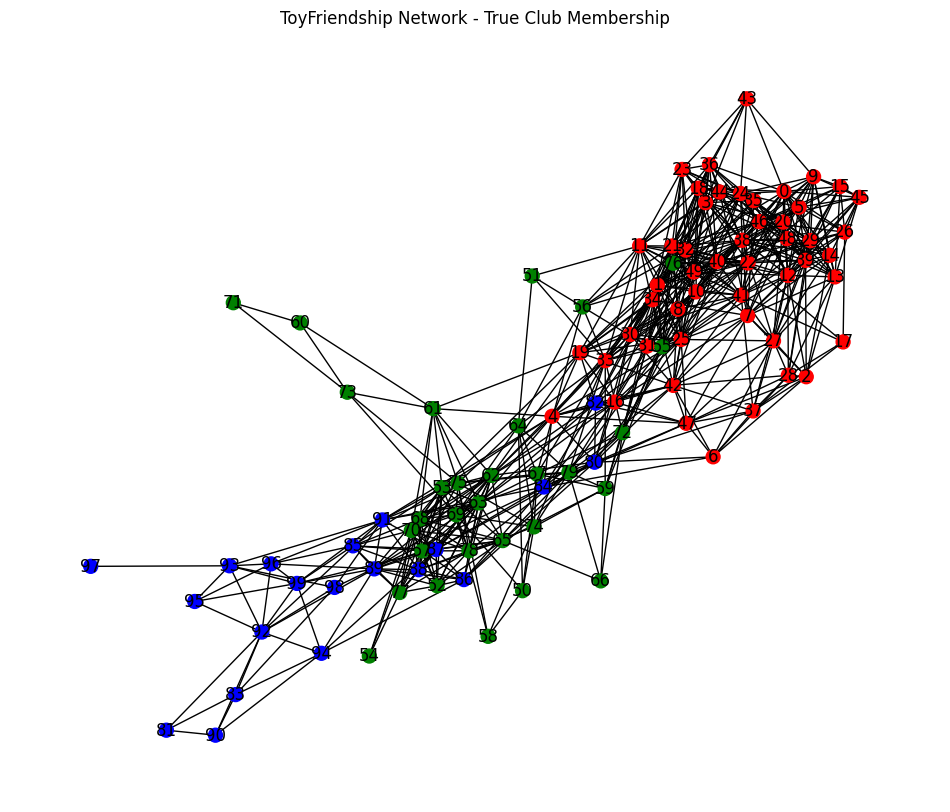

In [28]:
# Fix 1: Correct the set_node_attributes line (it's 'nx' not 'x')
nx.set_node_attributes(G, dict(zip(range(len(data.club)), data.club)), "club")

# Create node colors based on club membership
colors = []
for node in G.nodes(data=True):
    if node[1]['club'] == 'Sports':
        colors.append('red')
    elif node[1]['club'] == 'Music':
        colors.append('green')
    else:
        colors.append('blue')

# Fix 2: Remove edge_colors (or define it), Fix 3: Keep node_color on one line
plt.figure(figsize=(12, 10))
nx.draw_networkx(G, with_labels=True, width=1, node_size=100, node_color=colors)
plt.title("ToyFriendship Network - True Club Membership")
plt.axis('off')
plt.show()


In [35]:
import torch
from torch_geometric.utils import from_networkx, train_test_split_edges

# Step 1: Reload the original network data (without hidden node features)
# Start fresh from the NetworkX graph
G_original = nx.read_graphml('student_graph.graphml')
G_original.graph = {}

# Convert to PyTorch Geometric format with all node features
data_edge = from_networkx(G_original, group_node_attrs=["like_sports", "like_music", "like_science"])

print("Original ")
print(f"Number of nodes: {data_edge.num_nodes}")
print(f"Number of edges: {data_edge.num_edges}")
print(f"Node features shape: {data_edge.x.shape}")
print(f"Edge index shape: {data_edge.edge_index.shape}")

# Step 2: Split edges into train and test sets
# This function will:
# - Create training edges (for message passing)
# - Create test edges (positive examples to predict)
# - Create negative edges (non-existent edges, negative examples)
data_edge = train_test_split_edges(data_edge, val_ratio=0.0, test_ratio=0.2)

print("\n" + "="*70)
print("EDGE SPLIT SUMMARY")
print("="*70)

print(f"\nTraining edges:")
print(f"  - train_pos_edge_index shape: {data_edge.train_pos_edge_index.shape}")
print(f"  - Number of training edges: {data_edge.train_pos_edge_index.shape[1]}")

print(f"\nTest edges (positive - actual edges to predict):")
print(f"  - test_pos_edge_index shape: {data_edge.test_pos_edge_index.shape}")
print(f"  - Number of test positive edges: {data_edge.test_pos_edge_index.shape[1]}")

print(f"\nTest edges (negative - non-existent edges):")
print(f"  - test_neg_edge_index shape: {data_edge.test_neg_edge_index.shape}")
print(f"  - Number of test negative edges: {data_edge.test_neg_edge_index.shape[1]}")

print(f"\nNode features (unchanged):")
print(f"  - x shape: {data_edge.x.shape}")
print(f"  - All node features preserved: {data_edge.x.shape[0]} nodes, {data_edge.x.shape[1]} features")

# Verify the split
total_original_edges = G_original.number_of_edges() * 2  # Undirected, so counted twice
train_edges = data_edge.train_pos_edge_index.shape[1]
test_edges = data_edge.test_pos_edge_index.shape[1]

print(f"\n" + "="*70)
print("VERIFICATION")
print("="*70)
print(f"Original edges (directed): {total_original_edges}")
print(f"Training edges: {train_edges} ({train_edges/total_original_edges*100:.1f}%)")
print(f"Test positive edges: {test_edges} ({test_edges/total_original_edges*100:.1f}%)")
print(f"Test negative edges: {data_edge.test_neg_edge_index.shape[1]}")

# Show sample edges
print(f"\n" + "="*70)
print("SAMPLE EDGES")
print("="*70)

print("\nSample training edges (first 5):")
for i in range(min(5, data_edge.train_pos_edge_index.shape[1])):
    src = data_edge.train_pos_edge_index[0, i].item()
    dst = data_edge.train_pos_edge_index[1, i].item()
    print(f"  Edge {i+1}: Node {src} <-> Node {dst}")

print("\nSample test positive edges (first 5):")
for i in range(min(5, data_edge.test_pos_edge_index.shape[1])):
    src = data_edge.test_pos_edge_index[0, i].item()
    dst = data_edge.test_pos_edge_index[1, i].item()
    print(f"  Edge {i+1}: Node {src} <-> Node {dst} (should exist)")

print("\nSample test negative edges (first 5):")
for i in range(min(5, data_edge.test_neg_edge_index.shape[1])):
    src = data_edge.test_neg_edge_index[0, i].item()
    dst = data_edge.test_neg_edge_index[1, i].item()
    print(f"  Edge {i+1}: Node {src} <-> Node {dst} (should NOT exist)")


Is directed? False
Original 
Number of nodes: 100
Number of edges: 1356
Node features shape: torch.Size([100, 3])
Edge index shape: torch.Size([2, 1356])

EDGE SPLIT SUMMARY

Training edges:
  - train_pos_edge_index shape: torch.Size([2, 1086])
  - Number of training edges: 1086

Test edges (positive - actual edges to predict):
  - test_pos_edge_index shape: torch.Size([2, 135])
  - Number of test positive edges: 135

Test edges (negative - non-existent edges):
  - test_neg_edge_index shape: torch.Size([2, 135])
  - Number of test negative edges: 135

Node features (unchanged):
  - x shape: torch.Size([100, 3])
  - All node features preserved: 100 nodes, 3 features

VERIFICATION
Original edges (directed): 1356
Training edges: 1086 (80.1%)
Test positive edges: 135 (10.0%)
Test negative edges: 135

SAMPLE EDGES

Sample training edges (first 5):
  Edge 1: Node 0 <-> Node 9
  Edge 2: Node 0 <-> Node 12
  Edge 3: Node 0 <-> Node 14
  Edge 4: Node 0 <-> Node 15
  Edge 5: Node 0 <-> Node 20



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE

# Encoder class for VGAE
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


# Initialize the VGAE model
in_channels = data_edge.num_features  # 3 features (like_sports, like_music, like_science)
out_channels = 16  # Latent dimension

encoder = Encoder(in_channels, out_channels)
model = VGAE(encoder)

print("="*70)
print("VGAE MODEL ARCHITECTURE")
print("="*70)
print(f"\nEncoder:")
print(f"  Input features: {in_channels}")
print(f"  Hidden dimension: {2 * out_channels}")
print(f"  Latent dimension: {out_channels}")
print(f"\nModel structure:")
print(model)

# Check the encoder output dimensions
print(f"\n" + "="*70)
print("ENCODER OUTPUT DIMENSIONS")
print("="*70)
with torch.no_grad():
    mu, logstd = encoder(data_edge.x, data_edge.train_pos_edge_index)
    print(f"Mean (mu) shape: {mu.shape} - [{data_edge.num_nodes} nodes × {out_channels} latent dims]")
    print(f"Log std (logstd) shape: {logstd.shape} - [{data_edge.num_nodes} nodes × {out_channels} latent dims]")


VGAE MODEL ARCHITECTURE

Encoder:
  Input features: 3
  Hidden dimension: 32
  Latent dimension: 16

Model structure:
VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(3, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

ENCODER OUTPUT DIMENSIONS
Mean (mu) shape: torch.Size([100, 16]) - [100 nodes × 16 latent dims]
Log std (logstd) shape: torch.Size([100, 16]) - [100 nodes × 16 latent dims]


In [31]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt

# Ensure model and data are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_edge = data_edge.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("="*70)
print("VGAE TRAINING AND EVALUATION")
print("="*70)

# Training function - uses ONLY training edges
def train():
    model.train()
    optimizer.zero_grad()
    
    # IMPORTANT: Encode using ONLY training edges
    z = model.encode(data_edge.x, data_edge.train_pos_edge_index)
    
    # Compute reconstruction loss on training edges only
    loss = model.recon_loss(z, data_edge.train_pos_edge_index)
    
    # Add KL divergence regularization
    loss = loss + (1 / data_edge.num_nodes) * model.kl_loss()
    
    loss.backward()
    optimizer.step()
    
    return float(loss)

# Testing function - uses training edges for encoding, test edges for evaluation
def test(pos_edge_index, neg_edge_index):
    model.eval()
    
    with torch.no_grad():
        # IMPORTANT: Encode using ONLY training edges (not test edges!)
        # This ensures we don't leak information from test set
        z = model.encode(data_edge.x, data_edge.train_pos_edge_index)
        
        # Evaluate on test edges
        auc, ap = model.test(z, pos_edge_index, neg_edge_index)
    
    return auc, ap

# Training loop
print("\nTraining Progress:")
print(f"{'Epoch':<8} {'Loss':<12} {'Test AUC':<12} {'Test AP':<12}")
print("-"*70)

num_epochs = 200
best_auc = 0

for epoch in range(1, num_epochs + 1):
    loss = train()
    
    if epoch % 20 == 0:
        auc, ap = test(data_edge.test_pos_edge_index, data_edge.test_neg_edge_index)
        print(f"{epoch:<8} {loss:<12.4f} {auc:<12.4f} {ap:<12.4f}")
        
        if auc > best_auc:
            best_auc = auc

print("\n" + "="*70)
print("FINAL TEST EVALUATION")
print("="*70)

# Final comprehensive evaluation
model.eval()

with torch.no_grad():
    # Encode using TRAINING edges only
    z = model.encode(data_edge.x, data_edge.train_pos_edge_index)
    
    # Evaluate on TEST edges
    test_auc, test_ap = model.test(z, data_edge.test_pos_edge_index, 
                                     data_edge.test_neg_edge_index)
    
    # Get predictions for positive test edges
    pos_pred = model.decoder(z, data_edge.test_pos_edge_index, sigmoid=True)
    
    # Get predictions for negative test edges  
    neg_pred = model.decoder(z, data_edge.test_neg_edge_index, sigmoid=True)

print(f"\nTest Set Metrics:")
print(f"  AUC: {test_auc:.4f}")
print(f"  AP:  {test_ap:.4f}")

print(f"\nPrediction Statistics on Test Set:")
print(f"  Positive edges (should exist):")
print(f"    Mean: {pos_pred.mean().item():.4f}")
print(f"    Std:  {pos_pred.std().item():.4f}")
print(f"  Negative edges (should NOT exist):")
print(f"    Mean: {neg_pred.mean().item():.4f}")
print(f"    Std:  {neg_pred.std().item():.4f}")

# Detailed analysis
print("\n" + "="*70)
print("DETAILED TEST SET ANALYSIS")
print("="*70)

# Combine predictions and labels
all_preds = torch.cat([pos_pred, neg_pred]).cpu().numpy()
all_labels = torch.cat([
    torch.ones(pos_pred.shape[0]),
    torch.zeros(neg_pred.shape[0])
]).numpy()

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.5
binary_preds = (all_preds > threshold).astype(int)

precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)

print(f"\nWith threshold = {threshold}:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Count correct predictions
correct_pos = (pos_pred > threshold).sum().item()
correct_neg = (neg_pred < threshold).sum().item()
total_correct = correct_pos + correct_neg
total_test = len(pos_pred) + len(neg_pred)

print(f"\nAccuracy breakdown:")
print(f"  Positive edges correctly predicted: {correct_pos}/{len(pos_pred)} ({correct_pos/len(pos_pred)*100:.1f}%)")
print(f"  Negative edges correctly predicted: {correct_neg}/{len(neg_pred)} ({correct_neg/len(neg_pred)*100:.1f}%)")
print(f"  Overall accuracy: {total_correct}/{total_test} ({total_correct/total_test*100:.1f}%)")

# Show sample predictions
print("\n" + "="*70)
print("SAMPLE TEST PREDICTIONS")
print("="*70)

print("\nPositive test edges (first 10):")
print(f"{'Edge':<15} {'Probability':<12} {'Prediction':<12}")
print("-"*40)
for i in range(min(10, len(pos_pred))):
    src = data_edge.test_pos_edge_index[0, i].item()
    dst = data_edge.test_pos_edge_index[1, i].item()
    prob = pos_pred[i].item()
    pred_label = "EXISTS ✓" if prob > threshold else "NO EDGE ✗"
    print(f"{src:2d} <-> {dst:2d}      {prob:<12.4f} {pred_label}")

print("\nNegative test edges (first 10):")
print(f"{'Edge':<15} {'Probability':<12} {'Prediction':<12}")
print("-"*40)
for i in range(min(10, len(neg_pred))):
    src = data_edge.test_neg_edge_index[0, i].item()
    dst = data_edge.test_neg_edge_index[1, i].item()
    prob = neg_pred[i].item()
    pred_label = "NO EDGE ✓" if prob < threshold else "EXISTS ✗"
    print(f"{src:2d} <-> {dst:2d}      {prob:<12.4f} {pred_label}")

print("\n" + "="*70)
print("KEY POINTS ABOUT TRAIN/TEST SEPARATION")
print("="*70)
print("""
✓ CORRECT: During training, encode with train_pos_edge_index
✓ CORRECT: During testing, encode with train_pos_edge_index
✓ CORRECT: Evaluate predictions on test_pos_edge_index and test_neg_edge_index

✗ WRONG: Using test edges during encoding (information leakage!)
✗ WRONG: Evaluating on training edges (overly optimistic results)

The model learns node embeddings from training edges only.
Test edges are completely hidden during training and encoding.
This ensures fair evaluation of link prediction performance.
""")


VGAE TRAINING AND EVALUATION

Training Progress:
Epoch    Loss         Test AUC     Test AP     
----------------------------------------------------------------------
20       1.4067       0.8673       0.8514      
40       1.3082       0.8618       0.8463      
60       1.2147       0.8731       0.8605      
80       1.2041       0.8897       0.8753      
100      1.2063       0.8906       0.8516      
120      1.1696       0.8947       0.8569      
140      1.1380       0.9009       0.8717      
160      1.1765       0.9060       0.8843      
180      1.1773       0.9050       0.8758      
200      1.2018       0.9178       0.9055      

FINAL TEST EVALUATION

Test Set Metrics:
  AUC: 0.9178
  AP:  0.9055

Prediction Statistics on Test Set:
  Positive edges (should exist):
    Mean: 0.8122
    Std:  0.1185
  Negative edges (should NOT exist):
    Mean: 0.3966
    Std:  0.2529

DETAILED TEST SET ANALYSIS

With threshold = 0.5:
  Precision: 0.7333
  Recall:    0.9778
  F1-Score:  0.83

In [32]:
# Encode node embeddings using only training edges
z = model.encode(data_edge.x, data_edge.train_pos_edge_index)

# Compute likelihood matrix (reconstructed adjacency)
Ahat = torch.sigmoid(z @ z.t())  # Shape: [num_nodes, num_nodes]
print(f"Ahat shape: {Ahat.shape}")
print("Ahat[0,0] (self-loop):", Ahat[0,0].item())
print("Ahat[min,max]:", Ahat.min().item(), Ahat.max().item())



Ahat shape: torch.Size([100, 100])
Ahat[0,0] (self-loop): 0.9601903557777405
Ahat[min,max]: 0.04802856221795082 0.9834449291229248


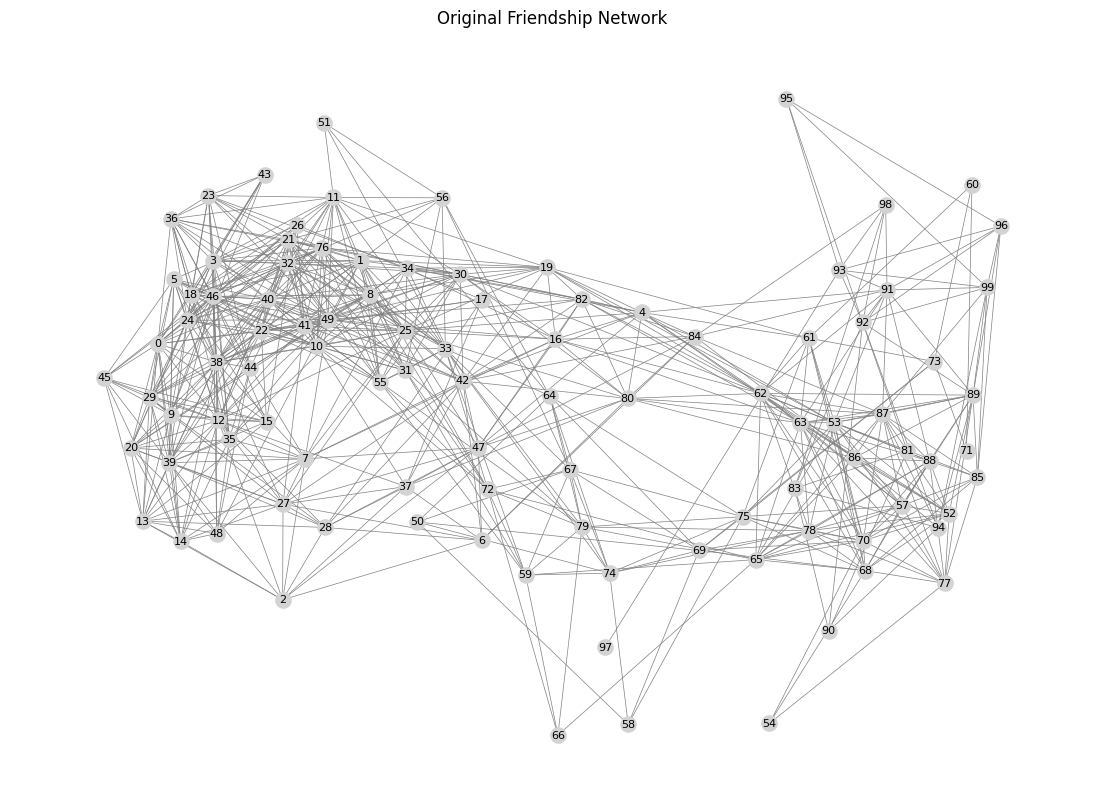

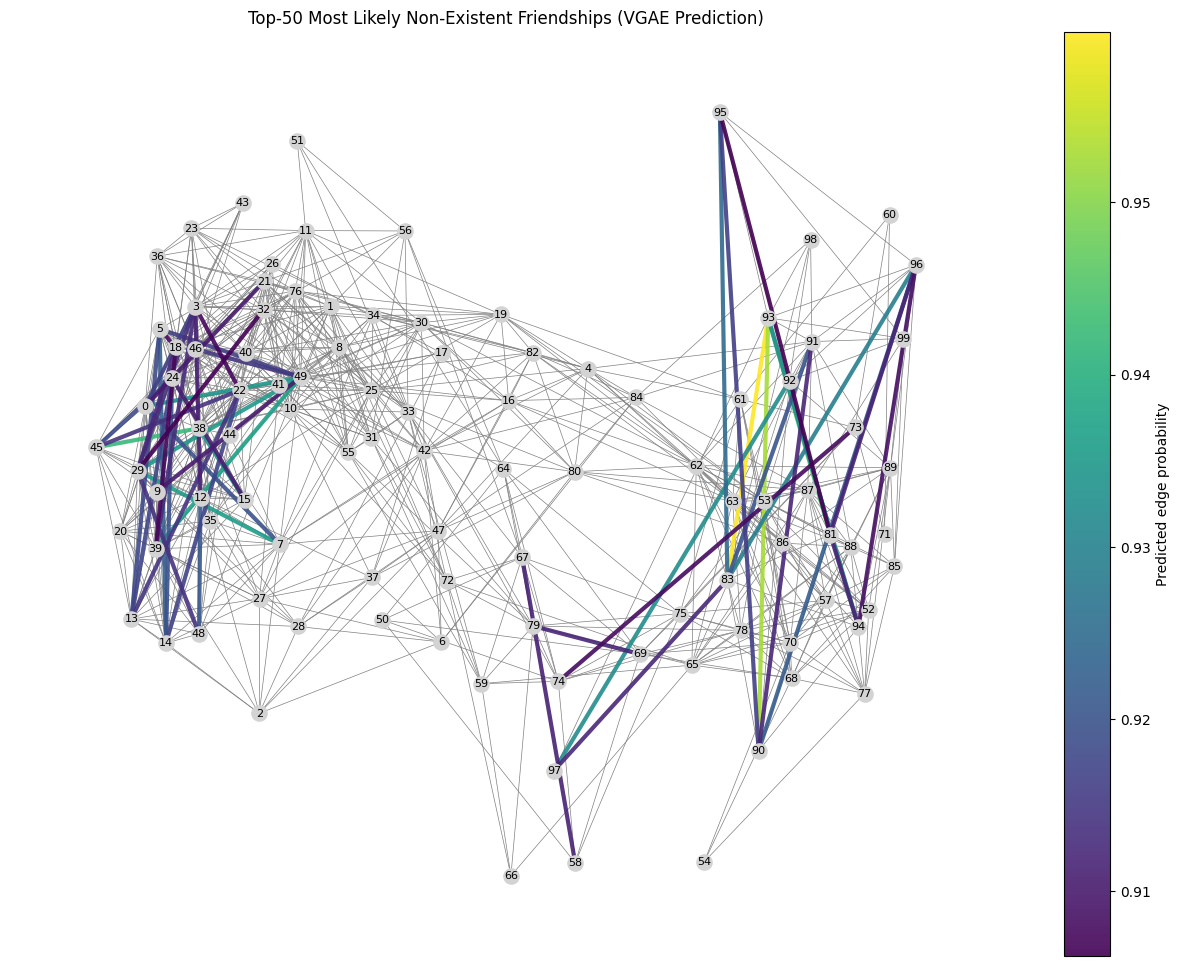

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 1. Plot the original network with true edges
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
nx.draw_networkx(G, pos, node_color="lightgray", node_size=120,
                 edge_color='gray', width=0.5, with_labels=True, font_size=8)
plt.title("Original Friendship Network")
plt.axis('off')
plt.show()

# 2. Visualize the top-N most likely edges (predicted by VGAE)
num_to_show = 50

# Get upper triangular (undirected, avoid duplicates)
Ahat_np = Ahat.detach().cpu().numpy()
np.fill_diagonal(Ahat_np, 0)  # Remove self-loops
triu_indices = np.triu_indices_from(Ahat_np, k=1)
edge_probs = Ahat_np[triu_indices]

# Get top-N most likely predicted edges (excluding actual edges)
sorted_indices = np.argsort(edge_probs)[::-1]
top_indices = list(zip(triu_indices[0][sorted_indices], triu_indices[1][sorted_indices]))

# Build a set for fast membership check
original_edges = set(G.edges())
pred_edges = []
pred_colors = []
for (i, j) in top_indices:
    # Convert integer indices to string to match G's node IDs
    i_str, j_str = str(i), str(j)
    if (i_str, j_str) not in original_edges and (j_str, i_str) not in original_edges:
        pred_edges.append((i_str, j_str))
        pred_colors.append(Ahat_np[i, j])
    if len(pred_edges) >= num_to_show:
        break

# Plot original graph + top-N predicted edges
plt.figure(figsize=(16, 12))
nx.draw_networkx(G, pos, node_color="lightgray", node_size=120,
                 edge_color='gray', width=0.5, with_labels=True, font_size=8)

# Overlay the top-N predicted edges (non-existent in the original), colored by probability
edges_collection = nx.draw_networkx_edges(
    G, pos,
    edgelist=pred_edges,
    edge_color=pred_colors,
    edge_cmap=plt.cm.viridis,
    width=3,
    alpha=0.9,
    label='VGAE-predicted likely edges'
)
plt.colorbar(edges_collection, label="Predicted edge probability")
plt.title(f"Top-{num_to_show} Most Likely Non-Existent Friendships (VGAE Prediction)")
plt.axis('off')
plt.show()